# Identifying Normal versus Abnormal Heart Sounds

Heart disease is one of the top causes of death throughout the world and often times if irregularities are identified soon enough preventative measures can be taken. The healthy heart makes a distinct ‘lub-dub’ sound at regular intervals. When there is disease or issues within the heart itself, such as defective valves, the sound patterns begin to diverge and this is something that trained health professionals can typically pickup on these abnormalities. By training a model off of healthy and unhealthy heart recordings, I will attempt to develop a model that can accurately predict the heart’s state and if further action needs to be taken. My idea for an end product would be some sort of software that could be integrated into a stethoscope that when placed on a patient’s heart during evaluation can help the doctor determine if there are any abnormalities in the heartbeat. The value from this would be improved patient care and outcomes which would ultimately lead to lower medical costs in the long run. A product such as this could also potentially be used by people without any medical training to quickly and accurately determine if there is an issue and if further action should be taken.

I will be using two separate datasets that contain recordings of heartbeats. One set contains just over 400 separate recordings with labels of normal and abnormal, as well as artifact recordings where there was an issue with the recording, for example too much background noise, that results in the actual heartbeat being indistinguishable. The other dataset contains over 3,000 recordings of both normal and abnormal heartbeats. With these recordings I can build a model to classify heartbeats as normal or abnormal or as an artifact that would cue the doctor to get another recording. My plan is to train the model on the larger dataset and than use the smaller dataset to test on. This will give a good sense of how generalizable the model is and if it would be effective in an actual clinical setting. After processing the data, I will apply both supervised and unsupervised learning techniques on the data in searching for the best performing model. In the end however, I anticipate that using deep learning techniques, particularly an LSTM recurrent neural network which have shown to be effective in such tasks as speech recognition, will ultimately produce the best model. 

In [1]:
# Pandas
import pandas as pd

# Scikit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_score

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical, np_utils
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger

# Audio
import librosa
import librosa.display
import wave
import IPython.display as ipd

# Plot
import matplotlib.pyplot as plt

# Utility
import os
from glob import glob
import numpy as np
from tqdm import tqdm
import itertools
import numpy as np
from scipy.io import wavfile
import fnmatch

Using TensorFlow backend.


## Preprocessing Data

In [2]:
def get_recording_times(audio_files):
    data = []
    for file in audio_files:
        y, sr = librosa.load(file)
        dur = librosa.get_duration(y)
        data.append(dur)
    return data

In [3]:
def get_mfcc(audio_files):
    data = []
    for file in audio_files:
        y, sr = librosa.load(file)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        data.append(mfccs)
    return data

In [4]:
# get audio data with a fix padding may also chop off some file
def load_file_mfcc (folder,file_names, duration=10, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                y = librosa.util.fix_length(X, input_length)                
            #normalized raw audio 
            # y = audio_norm(y)            
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)             
        except Exception as e:
            print("Error encountered while parsing file: ", file)        
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

In [162]:
# get audio data with a fix padding may also chop off some file
def load_file_spec (folder,file_names, duration=10, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                y = librosa.util.fix_length(X, input_length)                
            #normalized raw audio 
            # y = audio_norm(y)            
            # extract normalized spectrogram feature from data
            spec_features = librosa.amplitude_to_db(abs(librosa.stft(y)))
        except Exception as e:
            print("Error encountered while parsing file: ", file_name) 
        data.append(spec_features)
    return data

In [6]:
# Function to flatten out spectrogram and mfcc data
# This is used to easily separate out that data into individual columns that will be used for supervised learning
def flat_(file):
    data=[]
    for x in file:
        flat = x.flatten()
        data.append(flat)
    return data

In [7]:
#load dataset-a
set_a = pd.read_csv(r'\Users\mike1\Documents\Thinkful\training\training-a\REFERENCE.csv')
set_a['Status'] = np.where(set_a['Label'] >= 0, 'abnormal', 'normal')

#load dataset-b
set_b = pd.read_csv(r'\Users\mike1\Documents\Thinkful\training\training-b\REFERENCE.csv')
set_b['Status'] = np.where(set_b['Label'] >= 0, 'abnormal', 'normal')

#load dataset-c
set_c = pd.read_csv(r'\Users\mike1\Documents\Thinkful\training\training-c\REFERENCE.csv')
set_c['Status'] = np.where(set_c['Label'] >= 0, 'abnormal', 'normal')

#load dataset-d
set_d = pd.read_csv(r'\Users\mike1\Documents\Thinkful\training\training-d\REFERENCE.csv')
set_d['Status'] = np.where(set_d['Label'] >= 0, 'abnormal', 'normal')

#load dataset-e
set_e = pd.read_csv(r'\Users\mike1\Documents\Thinkful\training\training-e\REFERENCE.csv')
set_e['Status'] = np.where(set_e['Label'] >= 0, 'abnormal', 'normal')

#load dataset-f
set_f = pd.read_csv(r'\Users\mike1\Documents\Thinkful\training\training-f\REFERENCE.csv')
set_f['Status'] = np.where(set_f['Label'] >= 0, 'abnormal', 'normal')

In [8]:
data = './Documents/Thinkful/training/training-a'
audio_files_a = glob(data + '/*.wav')
print("Number of files in set a:", len(audio_files_a))

data = './Documents/Thinkful/training/training-b'
audio_files_b = glob(data + '/*.wav')
print("Number of files in set b:", len(audio_files_b))

data = './Documents/Thinkful/training/training-c'
audio_files_c = glob(data + '/*.wav')
print("Number of files in set c:", len(audio_files_c))

data = './Documents/Thinkful/training/training-d'
audio_files_d = glob(data + '/*.wav')
print("Number of files in set d:", len(audio_files_d))

data = './Documents/Thinkful/training/training-e'
audio_files_e = glob(data + '/*.wav')
print("Number of files in set e:", len(audio_files_e))

data = './Documents/Thinkful/training/training-f'
audio_files_f = glob(data + '/*.wav')
print("Number of files in set f:", len(audio_files_f))

Number of files in set a: 409
Number of files in set b: 490
Number of files in set c: 31
Number of files in set d: 55
Number of files in set e: 2141
Number of files in set f: 114


#### Get duration of each file

In [9]:
times_a = get_recording_times(audio_files_a)
duration = np.asarray(times_a)
set_a['duration'] = duration

In [10]:
times_b = get_recording_times(audio_files_b)
duration_b = np.asarray(times_b)
set_b['duration'] = duration_b

In [11]:
times_c = get_recording_times(audio_files_c)
duration_c = np.asarray(times_c)
set_c['duration'] = duration_c

In [12]:
times_d = get_recording_times(audio_files_d)
duration_d = np.asarray(times_d)
set_d['duration'] = duration_d

In [13]:
times_e = get_recording_times(audio_files_e)
duration_e = np.asarray(times_e)
set_e['duration'] = duration_e

In [14]:
times_f = get_recording_times(audio_files_f)
duration_f = np.asarray(times_f)
set_f['duration'] = duration_f

#### Get mfcc of each file

In [15]:
mfccs_a = get_mfcc(audio_files_a)

set_a['mfccs'] = mfccs_a

In [16]:
mfccs_b = get_mfcc(audio_files_b)

set_b['mfccs'] = mfccs_b

In [17]:
mfccs_c = get_mfcc(audio_files_c)

set_c['mfccs'] = mfccs_c

In [18]:
mfccs_d = get_mfcc(audio_files_d)

set_d['mfccs'] = mfccs_d

In [19]:
mfccs_e = get_mfcc(audio_files_e)

set_e['mfccs'] = mfccs_e

In [20]:
mfccs_f = get_mfcc(audio_files_f)

set_f['mfccs'] = mfccs_f

#### Get mean mfccs into data frame

In [21]:
# parent folder of sound files
INPUT_DIR = "./Documents"
# 16 KHz
SAMPLE_RATE = 16000
# seconds
MAX_SOUND_CLIP_DURATION = 10

In [22]:
A_folder=INPUT_DIR+'/Thinkful/training/training-a/'

A_files = fnmatch.filter(os.listdir(INPUT_DIR+'/Thinkful/training/training-a/'), 'a0*.wav')
A_sounds_mfcc = load_file_mfcc(folder=A_folder,file_names=A_files, duration=MAX_SOUND_CLIP_DURATION)

set_a['mean_mfccs'] = A_sounds_mfcc
set_a['mfccs_flat'] = flat_(A_sounds_mfcc)

In [23]:
B_folder=INPUT_DIR+'/Thinkful/training/training-b/'

B_files = fnmatch.filter(os.listdir(INPUT_DIR+'/Thinkful/training/training-b/'), 'b0*.wav')
B_sounds_mfcc = load_file_mfcc(folder=B_folder, file_names=B_files, duration=MAX_SOUND_CLIP_DURATION)

set_b['mean_mfccs'] = B_sounds_mfcc
set_b['mfccs_flat'] = flat_(B_sounds_mfcc)

In [24]:
C_folder=INPUT_DIR+'/Thinkful/training/training-c/'

C_files = fnmatch.filter(os.listdir(INPUT_DIR+'/Thinkful/training/training-c/'), 'c0*.wav')
C_sounds_mfcc = load_file_mfcc(folder=C_folder, file_names=C_files, duration=MAX_SOUND_CLIP_DURATION)

set_c['mean_mfccs'] = C_sounds_mfcc
set_c['mfccs_flat'] = flat_(C_sounds_mfcc)

In [25]:
D_folder=INPUT_DIR+'/Thinkful/training/training-d/'

D_files = fnmatch.filter(os.listdir(INPUT_DIR+'/Thinkful/training/training-d/'), 'd0*.wav')
D_sounds_mfcc = load_file_mfcc(folder=D_folder, file_names=D_files, duration=MAX_SOUND_CLIP_DURATION)

set_d['mean_mfccs'] = D_sounds_mfcc
set_d['mfccs_flat'] = flat_(D_sounds_mfcc)

In [26]:
E_folder=INPUT_DIR+'/Thinkful/training/training-e/'

E_files = fnmatch.filter(os.listdir(INPUT_DIR+'/Thinkful/training/training-e/'), 'e*.wav')
E_sounds_mfcc = load_file_mfcc(folder=E_folder, file_names=E_files, duration=MAX_SOUND_CLIP_DURATION)

set_e['mean_mfccs'] = E_sounds_mfcc
set_e['mfccs_flat'] = flat_(E_sounds_mfcc)

In [27]:
F_folder=INPUT_DIR+'/Thinkful/training/training-f/'

F_files = fnmatch.filter(os.listdir(INPUT_DIR+'/Thinkful/training/training-f/'), 'f0*.wav')
F_sounds_mfcc = load_file_mfcc(folder=F_folder, file_names=F_files, duration=MAX_SOUND_CLIP_DURATION)

set_f['mean_mfccs'] = F_sounds_mfcc
set_f['mfccs_flat'] = flat_(F_sounds_mfcc)

#### Get spectrogram data into data frames

In [164]:
A_sounds_spec = load_file_spec(folder=A_folder,file_names=A_files, duration=40)

set_a['spec'] = A_sounds_spec
set_a['spec_flat'] = flat_(A_sounds_spec)
set_a.head()

File  Label    Status   duration  \
0  a0001      1  abnormal  35.666032   
1  a0002      1  abnormal  20.828526   
2  a0003      1  abnormal  30.720000   
3  a0004      1  abnormal  35.596508   
4  a0005      1  abnormal  35.666032   

                                               mfccs  \
0  [[-577.35004, -577.43896, -577.81445, -578.706...   
1  [[-522.67773, -550.62177, -604.59705, -615.476...   
2  [[-562.017, -575.2533, -497.7878, -448.69955, ...   
3  [[-510.0188, -531.3734, -556.08887, -550.3389,...   
4  [[-500.7268, -500.3392, -497.16217, -496.6718,...   

                                          mean_mfccs  \
0  [[-584.12305], [131.81575], [86.7822], [35.868...   
1  [[-624.69977], [154.64249], [103.97029], [47.4...   
2  [[-591.2136], [86.8231], [65.5765], [41.115738...   
3  [[-551.03973], [101.06604], [77.66607], [49.60...   
4  [[-479.96585], [74.80587], [62.644917], [47.63...   

                                          mfccs_flat  \
0  [-584.12305, 131.81575, 86.7822, 35.868633, 0....   
1  [-624.69977, 154.64249, 103.97029, 47.453476, ...   
2  [-591.2136, 86.8231, 65.5765, 41.115738, 23.12...   
3  [-551.03973, 101.06604, 77.66607, 49.601433, 2...   
4  [-479.96585, 74.80587, 62.644917, 47.637768, 3...   

                                                spec  \
0  [[16.930475, 2.5290303, -3.2473829, -10.65361,...   
1  [[10.3798685, 4.566904, -25.60113, -6.7435837,...   
2  [[7.5731106, -2.8729043, -35.766533, -21.38292...   
3  [[21.330711, 10.455933, 2.3204412, -0.7993345,...   
4  [[15.463328, 13.978366, 2.703687, 6.897751, 10...   

                                           spec_flat  
0  [16.930475, 2.5290303, -3.2473829, -10.65361, ...  
1  [10.3798685, 4.566904, -25.60113, -6.7435837, ...  
2  [7.5731106, -2.8729043, -35.766533, -21.382921...  
3  [21.330711, 10.455933, 2.3204412, -0.7993345, ...  
4  [15.463328, 13.978366, 2.703687, 6.897751, 10....

In [29]:
B_sounds_spec = load_file_spec(folder=B_folder,file_names=B_files, duration=MAX_SOUND_CLIP_DURATION)

set_b['spec'] = B_sounds_spec
set_b['spec_flat'] = flat_(B_sounds_spec)
set_b.head()

File  Label  Status  duration  \
0  b0001     -1  normal       8.0   
1  b0002     -1  normal       8.0   
2  b0003     -1  normal       8.0   
3  b0004     -1  normal       8.0   
4  b0005     -1  normal       8.0   

                                               mfccs  \
0  [[-425.70508, -427.64404, -431.95074, -431.296...   
1  [[-413.3923, -431.15628, -450.4801, -449.43005...   
2  [[-444.90756, -445.67072, -447.52933, -450.643...   
3  [[-440.11932, -438.5854, -441.149, -440.42072,...   
4  [[-427.35287, -421.83408, -425.90213, -429.638...   

                                          mean_mfccs  \
0  [[-428.33002], [89.19388], [69.03256], [45.329...   
1  [[-444.91922], [61.66955], [55.937687], [48.34...   
2  [[-442.75323], [67.52865], [56.93366], [43.824...   
3  [[-415.27402], [128.11131], [93.46588], [52.79...   
4  [[-440.1965], [111.85874], [83.767715], [50.96...   

                                          mfccs_flat  \
0  [-428.33002, 89.19388, 69.03256, 45.32981, 26....   
1  [-444.91922, 61.66955, 55.937687, 48.345165, 4...   
2  [-442.75323, 67.52865, 56.93366, 43.824787, 32...   
3  [-415.27402, 128.11131, 93.46588, 52.798344, 1...   
4  [-440.1965, 111.85874, 83.767715, 50.969475, 2...   

                                                spec  
0  [33.850258, 38.4699, 40.311478, 38.669174, 37....  
1  [44.108105, 35.862938, 32.31117, 23.225803, 33...  
2  [25.63215, 34.06247, 34.22364, 24.006655, 28.1...  
3  [46.74419, 48.1094, 48.435806, 48.174667, 49.5...  
4  [43.368053, 43.348793, 45.119167, 48.407806, 4...

In [170]:
C_sounds_spec = load_file_spec(folder=C_folder, file_names=C_files, duration=130)

set_c['spec'] = C_sounds_spec
set_c['spec_flat'] = flat_(C_sounds_spec)
set_c.head()

File  Label    Status   duration  \
0  c0001      1  abnormal  22.723039   
1  c0002      1  abnormal  11.576508   
2  c0003     -1    normal  32.647528   
3  c0004      1  abnormal  57.472517   
4  c0005      1  abnormal   9.649025   

                                               mfccs  \
0  [[-537.0891, -559.61206, -586.43115, -586.3517...   
1  [[-553.62445, -545.4873, -562.3448, -592.3907,...   
2  [[-434.99728, -435.56168, -436.58798, -425.780...   
3  [[-494.59534, -497.4984, -517.876, -570.79346,...   
4  [[-438.7949, -493.72552, -629.89154, -628.3612...   

                                          mean_mfccs  \
0  [[-596.31177], [68.49968], [58.036194], [45.15...   
1  [[-603.52515], [73.355804], [62.480667], [49.0...   
2  [[-397.82587], [111.454], [85.508156], [54.784...   
3  [[-575.80817], [64.47537], [56.450996], [46.93...   
4  [[-619.18054], [81.033226], [65.58317], [47.87...   

                                          mfccs_flat  \
0  [-596.31177, 68.49968, 58.036194, 45.15881, 33...   
1  [-603.52515, 73.355804, 62.480667, 49.04001, 3...   
2  [-397.82587, 111.454, 85.508156, 54.78457, 29....   
3  [-575.80817, 64.47537, 56.450996, 46.933193, 3...   
4  [-619.18054, 81.033226, 65.58317, 47.877953, 3...   

                                                spec  \
0  [[9.127449, 4.925313, 0.9135601, -0.5175357, 0...   
1  [[9.336601, -21.031895, 3.4019036, 8.666872, 1...   
2  [[29.160522, 23.953335, 14.117675, 20.369017, ...   
3  [[24.06858, 22.777597, 12.1441555, 16.183226, ...   
4  [[19.38084, 11.4603815, 6.451934, -11.919996, ...   

                                           spec_flat  
0  [9.127449, 4.925313, 0.9135601, -0.5175357, 0....  
1  [9.336601, -21.031895, 3.4019036, 8.666872, 1....  
2  [29.160522, 23.953335, 14.117675, 20.369017, 1...  
3  [24.06858, 22.777597, 12.1441555, 16.183226, -...  
4  [19.38084, 11.4603815, 6.451934, -11.919996, 5...

In [32]:
D_sounds_spec = load_file_spec(folder=D_folder, file_names=D_files, duration=MAX_SOUND_CLIP_DURATION)

set_d['spec'] = D_sounds_spec
set_d['spec_flat'] = flat_(D_sounds_spec)
set_d.head()

File  Label    Status   duration  \
0  d0001     -1    normal   6.607528   
1  d0002      1  abnormal  10.846531   
2  d0003      1  abnormal  11.040000   
3  d0004      1  abnormal   9.514014   
4  d0005     -1    normal   9.417506   

                                               mfccs  \
0  [[-563.5371, -585.2326, -605.7634, -597.6385, ...   
1  [[-649.3677, -645.18665, -618.6927, -612.8838,...   
2  [[-640.9133, -640.9133, -640.9133, -640.9133, ...   
3  [[-700.45624, -714.72156, -728.7673, -721.0788...   
4  [[-437.48355, -468.68823, -515.1878, -510.1223...   

                                          mean_mfccs  \
0  [[-586.3175], [89.829056], [73.24019], [52.525...   
1  [[-662.9022], [101.23994], [79.77684], [52.800...   
2  [[-590.3947], [83.68325], [68.02001], [48.6889...   
3  [[-720.0838], [150.38322], [108.2894], [58.586...   
4  [[-509.1679], [76.076904], [64.01096], [48.952...   

                                          mfccs_flat  \
0  [-586.3175, 89.829056, 73.24019, 52.525528, 33...   
1  [-662.9022, 101.23994, 79.77684, 52.800724, 28...   
2  [-590.3947, 83.68325, 68.02001, 48.68895, 32.1...   
3  [-720.0838, 150.38322, 108.2894, 58.58677, 19....   
4  [-509.1679, 76.076904, 64.01096, 48.95294, 35....   

                                                spec  \
0  [[26.0322, 23.222176, 21.408695, 12.73477, 23....   
1  [[26.0322, 23.222176, 21.408695, 12.73477, 23....   
2  [[26.0322, 23.222176, 21.408695, 12.73477, 23....   
3  [[26.0322, 23.222176, 21.408695, 12.73477, 23....   
4  [[20.520935, 17.51702, 10.751545, 17.707968, 2...   

                                           spec_flat  
0  [26.0322, 23.222176, 21.408695, 12.73477, 23.7...  
1  [26.0322, 23.222176, 21.408695, 12.73477, 23.7...  
2  [26.0322, 23.222176, 21.408695, 12.73477, 23.7...  
3  [26.0322, 23.222176, 21.408695, 12.73477, 23.7...  
4  [20.520935, 17.51702, 10.751545, 17.707968, 20...

In [ ]:
E_sounds_spec = load_file_spec(folder=E_folder, file_names=E_files, duration=100)

set_e['spec'] = E_sounds_spec
set_e['spec_flat'] = flat_(E_sounds_spec)
set_e.head()

In [169]:
F_sounds_spec = load_file_spec(folder=F_folder, file_names=F_files, duration=60)

set_f['spec'] = F_sounds_spec
set_f['spec_flat'] = flat_(F_sounds_spec)
set_f.head()

File  Label    Status   duration  \
0  f0001     -1    normal  31.824036   
1  f0002     -1    normal  30.336009   
2  f0003      1  abnormal  31.824036   
3  f0004     -1    normal  35.136009   
4  f0005     -1    normal  39.744036   

                                               mfccs  \
0  [[-560.88446, -461.15402, -410.48718, -408.359...   
1  [[-545.3066, -454.88354, -391.6008, -378.43057...   
2  [[-594.80505, -476.39822, -412.7374, -399.4355...   
3  [[-565.06006, -490.57462, -434.12436, -423.709...   
4  [[-572.90546, -485.4269, -397.61954, -368.9902...   

                                          mean_mfccs  \
0  [[-457.0023], [150.62352], [103.12862], [47.41...   
1  [[-431.00134], [160.76947], [107.860275], [46....   
2  [[-466.4491], [171.6018], [110.55385], [41.499...   
3  [[-453.95312], [149.65536], [102.850105], [48....   
4  [[-458.92902], [157.95464], [108.54861], [51.1...   

                                          mfccs_flat  \
0  [-457.0023, 150.62352, 103.12862, 47.41841, 4....   
1  [-431.00134, 160.76947, 107.860275, 46.743397,...   
2  [-466.4491, 171.6018, 110.55385, 41.49928, -6....   
3  [-453.95312, 149.65536, 102.850105, 48.202785,...   
4  [-458.92902, 157.95464, 108.54861, 51.18382, 8...   

                                                spec  \
0  [[-26.098223, -29.81038, -33.70213, -23.0839, ...   
1  [[-13.591049, -7.821441, -8.127715, -11.946565...   
2  [[-32.8702, -31.41224, -16.477978, -16.453255,...   
3  [[-29.489824, -20.644493, -11.208548, -32.7738...   
4  [[-31.501406, -8.005298, -2.1463196, -11.52686...   

                                           spec_flat  
0  [-26.098223, -29.81038, -33.70213, -23.0839, -...  
1  [-13.591049, -7.821441, -8.127715, -11.946565,...  
2  [-32.8702, -31.41224, -16.477978, -16.453255, ...  
3  [-29.489824, -20.644493, -11.208548, -32.77387...  
4  [-31.501406, -8.005298, -2.1463196, -11.52686,...

#### Join all sets into one data frame

In [37]:
frames = [set_a, set_b, set_c, set_d, set_e, set_f]
heart_sounds = pd.concat(frames)
heart_sounds.loc[heart_sounds.Label == -1, 'Label'] = 0
print(heart_sounds.info())

C:\Users\mike1\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3240 entries, 0 to 113
Data columns (total 9 columns):
File          3240 non-null object
Label         3240 non-null int64
Status        3240 non-null object
duration      3240 non-null float64
mean_mfccs    3240 non-null object
mfccs         3240 non-null object
mfccs_flat    3240 non-null object
spec          545 non-null object
spec_flat     545 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 253.1+ KB
None


## Data Exploration

normal      2575
abnormal     665
Name: Status, dtype: int64


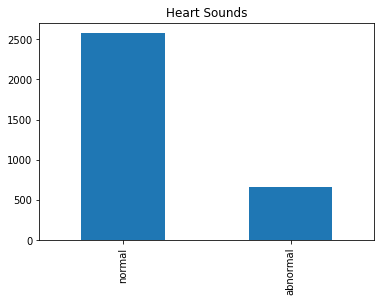

In [39]:
print(heart_sounds['Status'].value_counts())

heart_sounds['Status'].value_counts().plot.bar(title = "Heart Sounds")

Average recording time: 22.46177035917244 seconds
Smallest recording time: 5.305532879818594 seconds
Longest recording time: 121.99850340136054 seconds


(array([1.142e+03, 1.192e+03, 7.420e+02, 1.040e+02, 2.800e+01, 1.200e+01,
        6.000e+00, 8.000e+00, 5.000e+00, 1.000e+00]),
 array([  5.30553288,  16.97482993,  28.64412698,  40.31342404,
         51.98272109,  63.65201814,  75.32131519,  86.99061224,
         98.6599093 , 110.32920635, 121.9985034 ]),
 <a list of 10 Patch objects>)

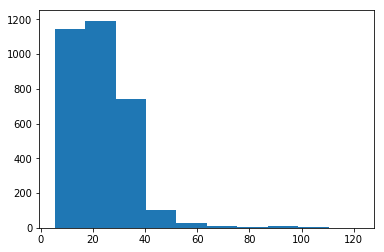

In [46]:
# Time Distribution
print("Average recording time:", np.mean(heart_sounds['duration']), "seconds")
print("Smallest recording time:", np.min(heart_sounds['duration']), "seconds")
print("Longest recording time:", np.max(heart_sounds['duration']), "seconds")

plt.hist(heart_sounds['duration'])

We see that in our training dataset there appear to be more normal heart sounds than abnormal. This will be important to consider once we begin modelling. Also, from the time distribution we see that the recordings last predominantly between 5 and 40 seconds. But for now let's listen to some hearts. 

### Audio Recordings

1. Normal case

In the Normal category there are normal, healthy heart sounds. These may contain noise in the final second of the recording as the device is removed from the body. They may contain a variety of background noises (from traffic to radios). They may also contain occasional random noise corresponding to breathing, or brushing the microphone against clothing or skin. A normal heart sound has a clear “lub dub, lub dub” pattern, with the time from “lub” to “dub” shorter than the time from “dub” to the next “lub” (when the heart rate is less than 140 beats per minute)(source: Rita Getz)

In [47]:
# A normal heart sound from set-a
ipd.Audio(audio_files_a[9]) 

In [48]:
# A normal heart sound from set-c
ipd.Audio(audio_files_c[6]) 

In [64]:
# A normal heart sound from set-d
ipd.Audio(audio_files_d[4])

2. Abnormal/Murmur

Heart murmurs sound as though there is a “whooshing, roaring, rumbling, or turbulent fluid” noise in one of two temporal locations: (1) between “lub” and “dub”, or (2) between “dub” and “lub”. They can be a symptom of many heart disorders, some serious. There will still be a “lub” and a “dub”. One of the things that confuses non-medically trained people is that murmurs happen between lub and dub or between dub and lub; not on lub and not on dub.(source: Rita Getz)

In [70]:
# Abnormal heart sound from set-a
ipd.Audio(audio_files_a[10]) 

In [68]:
# Abnormal heart sound from set-c
ipd.Audio(audio_files_c[7]) 

In [69]:
# Abnormal heart sound from set-d
ipd.Audio(audio_files_d[3])

### Visualizing normal versus abnormal 

Using the same sounds as from above 

### Waveplots

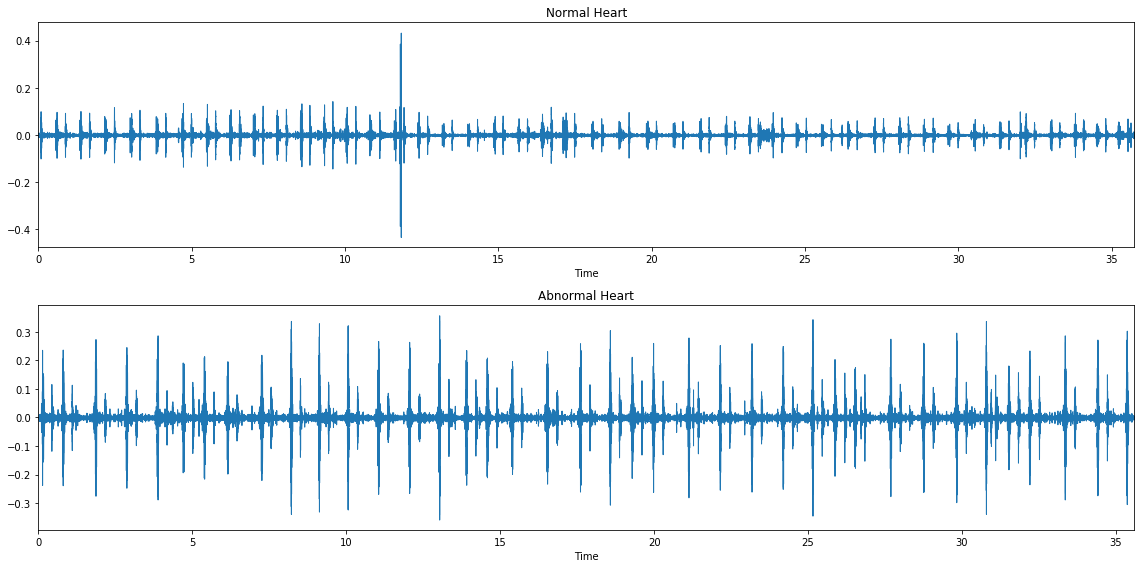

In [58]:
# librosa plot -- set-a
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
y, sr = librosa.load(audio_files_a[9])
librosa.display.waveplot(y, sr=sr)
plt.title("Normal Heart")

plt.subplot(2, 1, 2)
y, sr = librosa.load(audio_files_a[10])
librosa.display.waveplot(y, sr=sr)
plt.title("Abnormal Heart")

plt.tight_layout()
plt.show()

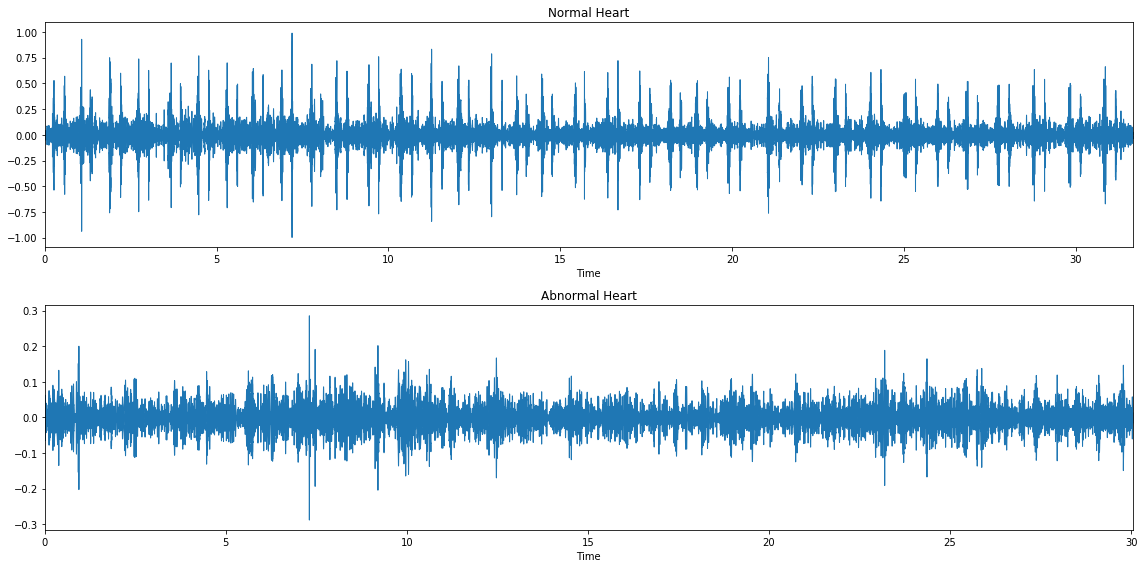

In [53]:
# librosa plot
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
y, sr = librosa.load(audio_files_c[6])
librosa.display.waveplot(y, sr=sr)
plt.title("Normal Heart")

plt.subplot(2, 1, 2)
y, sr = librosa.load(audio_files_c[7])
librosa.display.waveplot(y, sr=sr)
plt.title("Abnormal Heart")

plt.tight_layout()
plt.show()

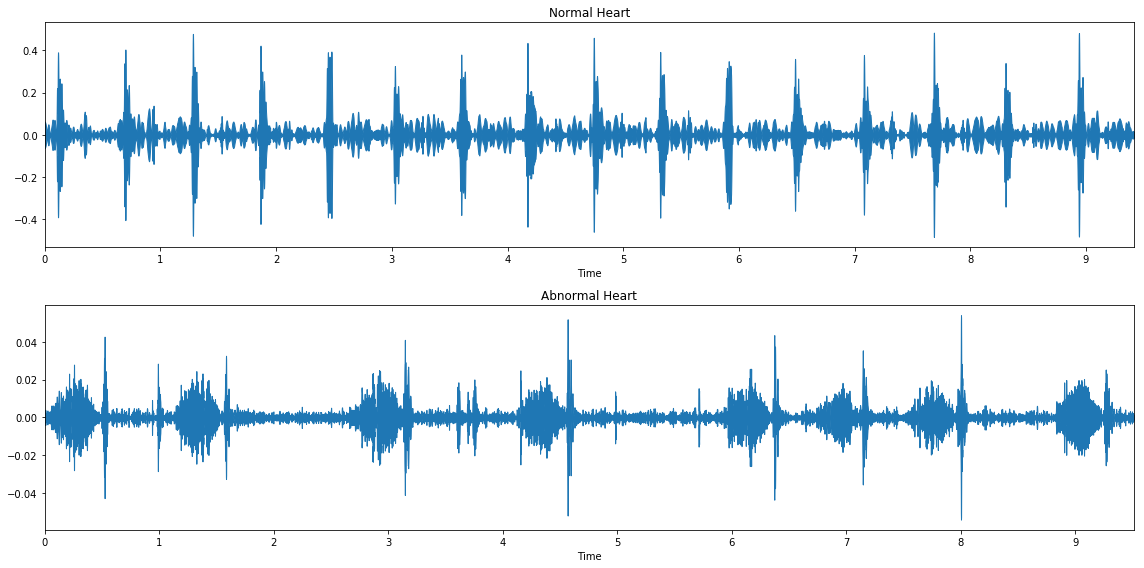

In [65]:
# librosa plot -- set-d
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
y, sr = librosa.load(audio_files_d[4])
librosa.display.waveplot(y, sr=sr)
plt.title("Normal Heart")

plt.subplot(2, 1, 2)
y, sr = librosa.load(audio_files_d[3])
librosa.display.waveplot(y, sr=sr)
plt.title("Abnormal Heart")

plt.tight_layout()
plt.show()

### Spectrograms

A spectrogram is the visual representation of the spectrum of frequencies of a signal as it varies with time. By converting the audio into a visual representation we can then perform similar methods of classification such as would be done when trying to classifying or identifying certain images. A famous example of this method has been done in identifying bird calls so its possible using this data will also be able to identify normal versus abnormal heart sounds. 

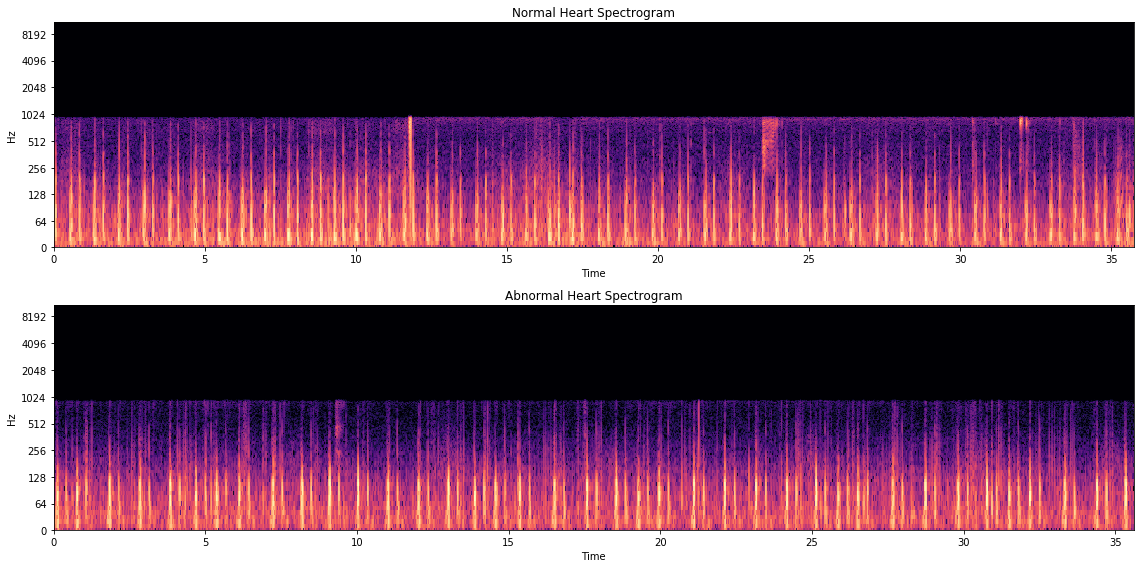

In [55]:
# librosa spectrogram plot -- set-a
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
y, sr = librosa.load(audio_files_a[9])
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, x_axis='time', y_axis='log')
plt.title("Normal Heart Spectrogram")

plt.subplot(2, 1, 2)
y, sr = librosa.load(audio_files_a[10])
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, x_axis='time', y_axis='log')
plt.title("Abnormal Heart Spectrogram")

plt.tight_layout()
plt.show()

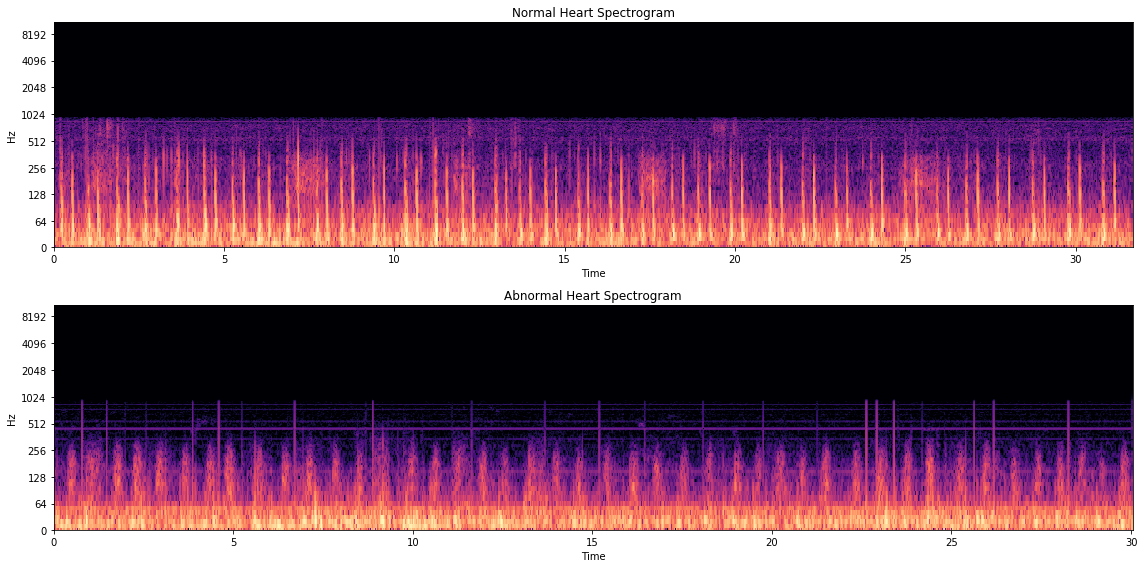

In [56]:
# librosa spectrogram plot -- set-c
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
y, sr = librosa.load(audio_files_c[6])
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, x_axis='time', y_axis='log')
plt.title("Normal Heart Spectrogram")

plt.subplot(2, 1, 2)
y, sr = librosa.load(audio_files_c[7])
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, x_axis='time', y_axis='log')
plt.title("Abnormal Heart Spectrogram")

plt.tight_layout()
plt.show()

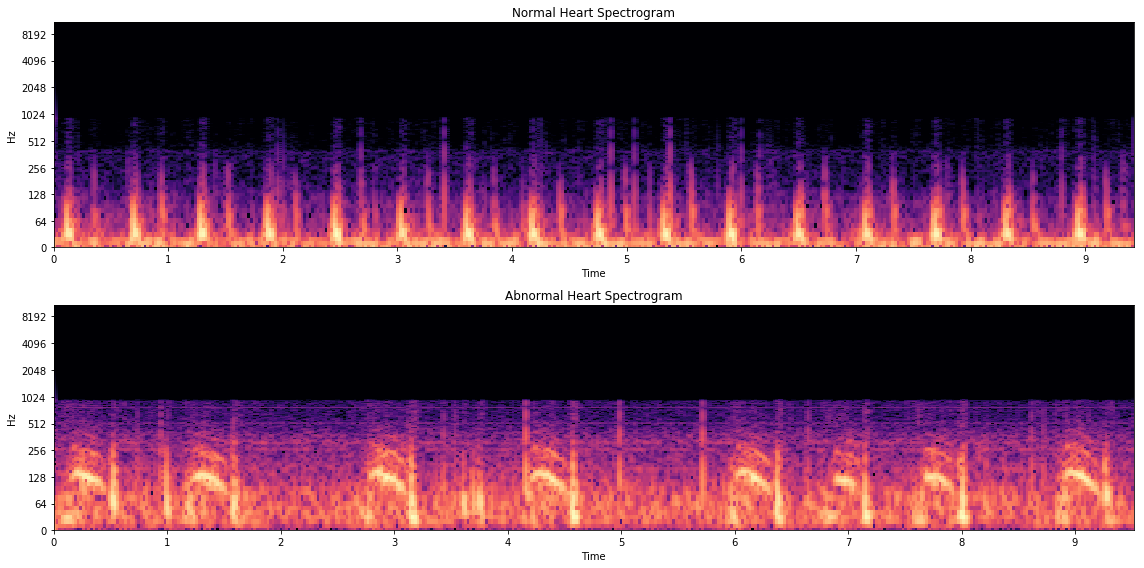

In [66]:
# librosa spectrogram plot -- set-d
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
y, sr = librosa.load(audio_files_d[4])
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, x_axis='time', y_axis='log')
plt.title("Normal Heart Spectrogram")

plt.subplot(2, 1, 2)
y, sr = librosa.load(audio_files_d[3])
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, x_axis='time', y_axis='log')
plt.title("Abnormal Heart Spectrogram")

plt.tight_layout()
plt.show()

### Mel-frequency Cepstrums

In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum. This frequency warping can allow for better representation of sound, for example, in audio compression (source: Wikipedia). 

MFCCs are commonly derived as follows:
1. Take the Fourier transform of (a windowed excerpt of) a signal.
2. Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
3. Take the logs of the powers at each of the mel frequencies.
4. Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
5. The MFCCs are the amplitudes of the resulting spectrum.

MFCCs have been shown to be particularly effective in speech-recognition systems so its possible they could also be useful for our classification question. 

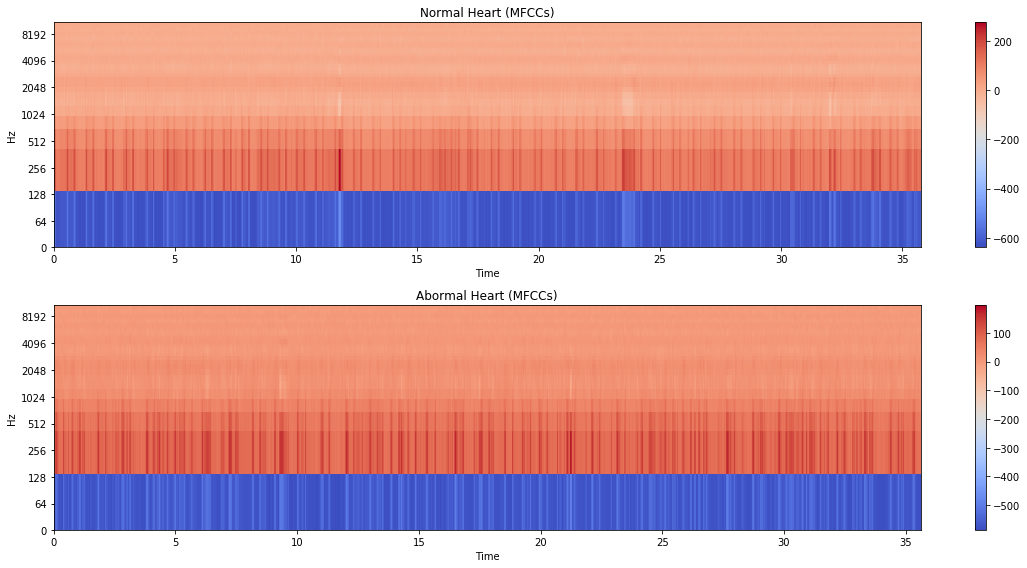

In [60]:
# librosa mfcc plot -- set-a
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
y, sr = librosa.load(audio_files_a[9])
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Normal Heart (MFCCs)')

plt.subplot(2, 1, 2)
y, sr = librosa.load(audio_files_a[10])
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Abormal Heart (MFCCs)')

plt.tight_layout()
plt.show()

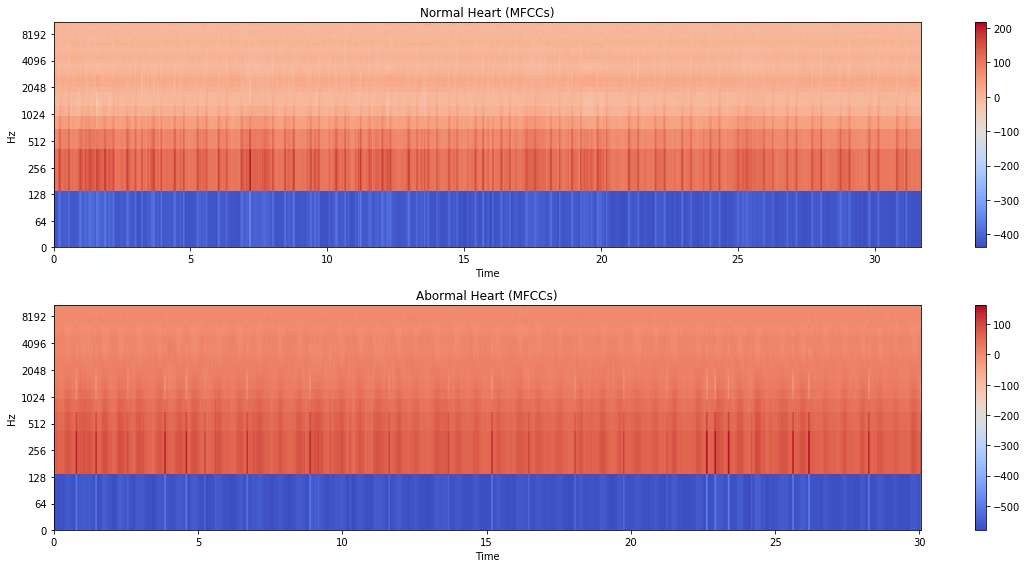

In [61]:
# librosa mfcc plot -- set-c
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
y, sr = librosa.load(audio_files_c[6])
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Normal Heart (MFCCs)')

plt.subplot(2, 1, 2)
y, sr = librosa.load(audio_files_c[7])
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Abormal Heart (MFCCs)')

plt.tight_layout()
plt.show()

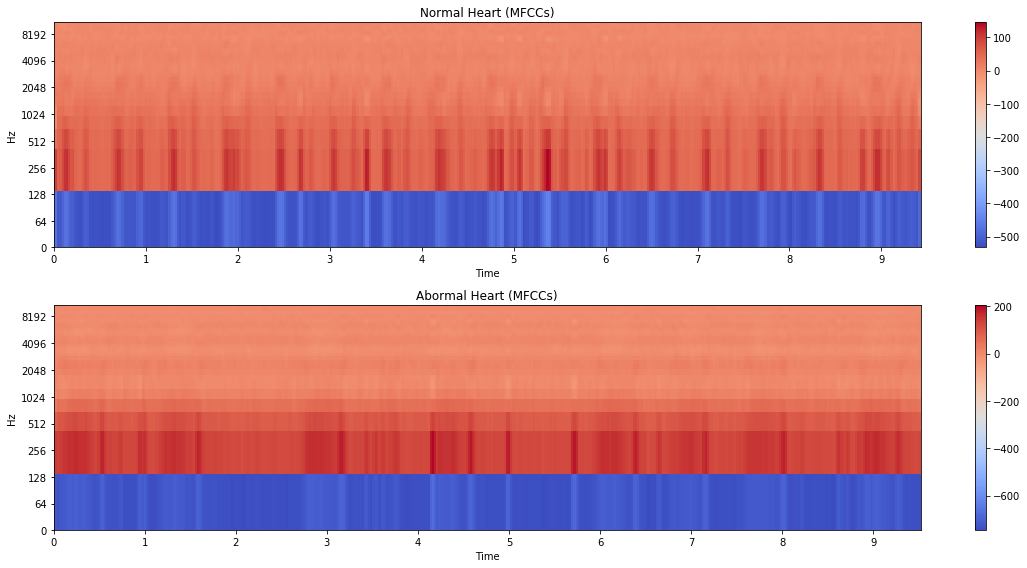

In [67]:
# librosa mfcc plot -- set-d
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
y, sr = librosa.load(audio_files_d[4])
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Normal Heart (MFCCs)')

plt.subplot(2, 1, 2)
y, sr = librosa.load(audio_files_d[3])
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Abormal Heart (MFCCs)')

plt.tight_layout()
plt.show()

4. Artifact

In the Artifact category there are a wide range of different sounds, including feedback squeals and echoes, speech, music and noise. There are usually no discernable heart sounds, and thus little or no temporal periodicity at frequencies below 195 Hz. This category is the most different from the others. It is important to be able to distinguish this category from the other three categories, so that someone gathering the data can be instructed to try again.(source: Rita Getz)

In [55]:
artifact = "./Documents/set_a/artifact__201012172012.wav"
ipd.Audio(artifact)

duration: 9.0
(198450,) 22050


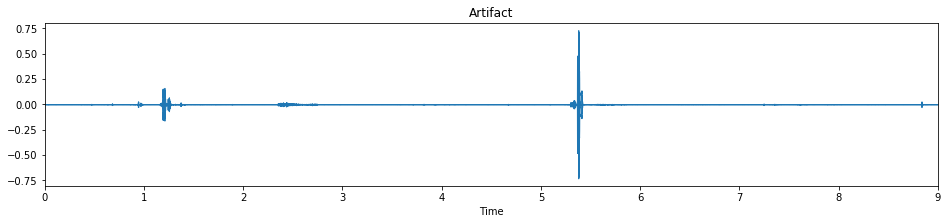

In [59]:
# Load using Librosa
y, sr = librosa.load(artifact)   #default sampling rate is 22 HZ
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y.shape, sr)

# librosa plot
plt.figure(figsize=(16, 3))
plt.title("Artifact")
librosa.display.waveplot(y, sr=sr)

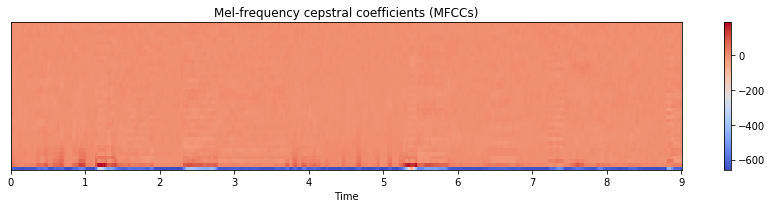

In [60]:
y, sr = librosa.load(artifact)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
#print (mfccs)
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()

Text(0.5, 1.0, 'Artifact spectogram')

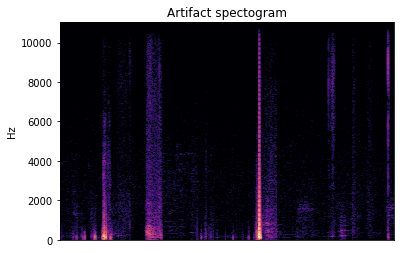

In [61]:
y, sr = librosa.load(artifact)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.title("Artifact spectogram")

## Models

## Supervised Learning

In [133]:
mean_mfcc = heart_sounds['mfccs_flat'].apply(pd.Series)
mean_mfcc = mean_mfcc.rename(columns = lambda x : 'mean_mfcc_' + str(x))
mean_mfcc.head()

mean_mfcc_0  mean_mfcc_1  mean_mfcc_2  mean_mfcc_3  mean_mfcc_4  \
0  -584.123047   131.815750    86.782204    35.868633     0.637819   
1  -624.699768   154.642487   103.970291    47.453476     7.985539   
2  -591.213623    86.823097    65.576500    41.115738    23.121069   
3  -551.039734   101.066040    77.666069    49.601433    26.863827   
4  -479.965851    74.805870    62.644917    47.637768    34.148006   

   mean_mfcc_5  mean_mfcc_6  mean_mfcc_7  mean_mfcc_8  mean_mfcc_9  ...  \
0    -8.510118     3.605546    22.122927    32.429489    28.660721  ...   
1    -3.840175     6.248580    22.152189    29.132095    22.484131  ...   
2    16.311895    18.820730    24.409809    26.756865    23.131069  ...   
3    15.175337    14.163008    18.698847    22.403854    21.294815  ...   
4    25.119581    21.141499    20.436937    20.358057    18.920044  ...   

   mean_mfcc_30  mean_mfcc_31  mean_mfcc_32  mean_mfcc_33  mean_mfcc_34  \
0      3.706730      0.434016     -1.259462     -0.561123      1.511565   
1      0.862969     -0.666601     -0.369653      1.183133      2.438900   
2      2.526340      1.325982      0.521455      0.678551      1.565351   
3      2.244988      2.005223      1.452044      0.980817      0.864941   
4      2.364192      2.444324      2.237772      1.817586      1.372011   

   mean_mfcc_35  mean_mfcc_36  mean_mfcc_37  mean_mfcc_38  mean_mfcc_39  
0      3.071774      2.858837      1.107444     -0.779155     -1.378706  
1      2.259497      0.824696     -0.648242     -1.018164     -0.156827  
2      2.310339      2.073606      0.720222     -1.021844     -2.049898  
3      1.099889      1.462111      1.695900      1.682644      1.487730  
4      1.064927      0.938371      0.923181      0.920599      0.877162  

[5 rows x 40 columns]

In [130]:
X = mean_mfcc
target = heart_sounds['Label']

X_train, X_test, y_train, y_test = train_test_split(X, target, train_size = 0.75)

C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [131]:
# Naive Bayes Model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(cross_val_score(bnb, X, target, cv = 5))

0.7271604938271605
[[474 190]
 [ 31 115]]
[0.16820988 0.79938272 0.90277778 0.8904321  0.87654321]


In [132]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(cross_val_score(lr, X, target, cv = 5))

C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8654320987654321
[[624  40]
 [ 69  77]]


C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

[0.49382716 0.85648148 0.78395062 0.92438272 0.84876543]


In [134]:
# Decision Tree Model
from sklearn import tree

# Decision Tree Model
decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_features = 1, max_depth = 5)
dtc = decision_tree.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(cross_val_score(dtc, X, target, cv = 5))

0.8493827160493828
[[603  61]
 [ 61  85]]
[0.26080247 0.78549383 0.79475309 0.89351852 0.90277778]


In [135]:
# KNN model
from sklearn.neighbors import KNeighborsClassifier

neighbors = KNeighborsClassifier(n_neighbors = 1)
neighbors.fit(X_train, y_train)
y_pred = neighbors.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(cross_val_score(neighbors, X, target, cv = 5))

0.8728395061728395
[[613  51]
 [ 52  94]]
[0.26388889 0.875      0.83796296 0.91512346 0.88117284]


In [136]:
# Random Forest Model
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(cross_val_score(rfc, X, target, cv = 5))

C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9037037037037037
[[640  24]
 [ 54  92]]
[0.28549383 0.90123457 0.8132716  0.91203704 0.92592593]


In [137]:
# Gradient Boosting Model
params = {'n_estimators': 150,
          'max_depth': 2,
          'loss': 'deviance'}

gb = ensemble.GradientBoostingClassifier(**params)
gb.fit(X_train, y_train)

print(accuracy_score(y_test, gb.predict(X_test)))
print(confusion_matrix(y_test, y_pred))
print(cross_val_score(gb, X, target, cv = 5))

0.9123456790123456
[[640  24]
 [ 54  92]]
[0.25617284 0.90277778 0.82253086 0.91666667 0.91975309]


## Unsupervised Learning

In [79]:
#Libraries for unsupervised learning
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sklearn.manifold import TSNE
import umap

In [80]:
# Target and data for the entire protein expression set
X = mean_mfcc
target = heart_sounds['Label']

# Normalize
X_std = StandardScaler().fit_transform(X)

C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


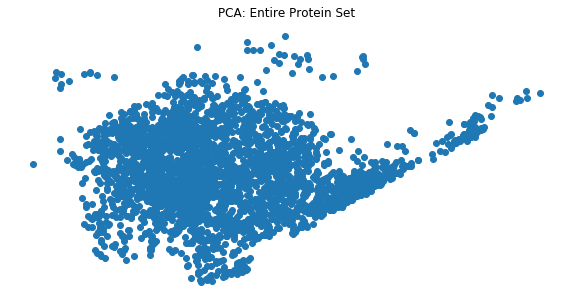

In [81]:
# visualize pca
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title("PCA: Mean_MFCCs")
plt.show()

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 3240 samples in 0.000s...
[t-SNE] Computed neighbors for 3240 samples in 0.664s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3240
[t-SNE] Computed conditional probabilities for sample 2000 / 3240
[t-SNE] Computed conditional probabilities for sample 3000 / 3240
[t-SNE] Computed conditional probabilities for sample 3240 / 3240
[t-SNE] Mean sigma: 1.018436
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.116539
[t-SNE] KL divergence after 300 iterations: 2.056657


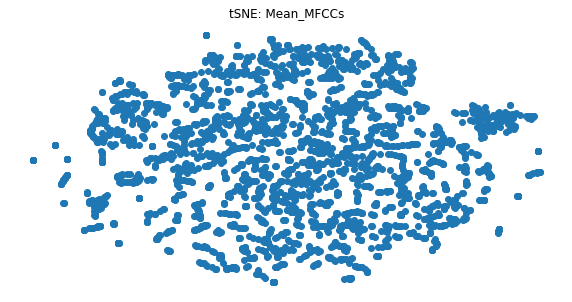

In [82]:
# visualize t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title("tSNE: Mean_MFCCs")
plt.show()

C:\Users\mike1\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 9 separate connected components using meta-embedding (experimental)
  n_components


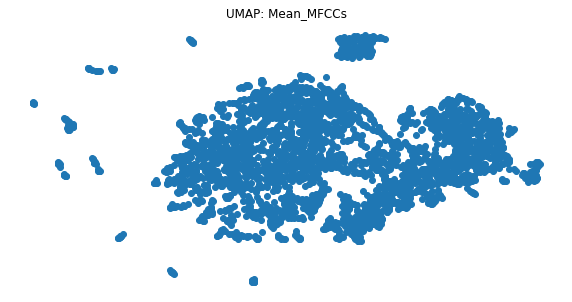

In [83]:
# visualize UMAP
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.5,
                      metric='correlation').fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title("UMAP: Mean_MFCCs")
plt.show()

In [84]:
## Check which number of clusters works best
n_clusters = [2, 3, 4, 5, 6, 7, 10, 20]

In [87]:
def compare_k_means(k_list, data):
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = KMeans(n_clusters=k, random_state=123)
        clusterer.fit(data)
        ##
        print("Adjusted Rand Index for k == {}: {}".format(k, metrics.adjusted_rand_score(target, clusterer.labels_)))
        print("Silhouette Coefficient for k == {}: {}".format(k, metrics.silhouette_score(data, clusterer.labels_)))
        print("\n")

In [88]:
# Evaluate k-means for the proteomes data
compare_k_means(n_clusters, X)

Adjusted Rand Index for k == 2: 0.13658449209268703
Silhouette Coefficient for k == 2: 0.43593114614486694


Adjusted Rand Index for k == 3: 0.06637149541243262
Silhouette Coefficient for k == 3: 0.36080417037010193


Adjusted Rand Index for k == 4: 0.04551712847232827
Silhouette Coefficient for k == 4: 0.3347816467285156


Adjusted Rand Index for k == 5: 0.030326487720311934
Silhouette Coefficient for k == 5: 0.3176664710044861


Adjusted Rand Index for k == 6: 0.019991689872466085
Silhouette Coefficient for k == 6: 0.28914663195610046


Adjusted Rand Index for k == 7: 0.020954290923622033
Silhouette Coefficient for k == 7: 0.2960786521434784


Adjusted Rand Index for k == 10: 0.01530255382952896
Silhouette Coefficient for k == 10: 0.27460727095603943


Adjusted Rand Index for k == 20: 0.00968438031479966
Silhouette Coefficient for k == 20: 0.24501225352287292




## Deep Learning

#### Format data for LSTM neural networks

In [141]:
x_data = np.concatenate((A_sounds_mfcc, B_sounds_mfcc, C_sounds_mfcc, D_sounds_mfcc, E_sounds_mfcc, F_sounds_mfcc))
x_data.shape

(3240, 40, 1)

In [142]:
# Map label text to integer
CLASSES = ['normal','abnormal']
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'normal': 0, 'abnormal': 1}
 
{0: 'normal', 1: 'abnormal'}


In [143]:
y_data = heart_sounds['Label']
y_data.shape

(3240,)

In [144]:
seed=1234
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9, random_state=seed, shuffle=True)
y_train = np.array(keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(keras.utils.to_categorical(y_test, len(CLASSES)))

C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [ ]:
seed = 1000
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9, random_state=seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=seed, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(keras.utils.to_categorical(test_y, len(CLASSES)))

### MLP

In [93]:
x_train_ = x_train.reshape(2916, 40)
x_test_ = x_test.reshape(324, 40)

# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(64, activation='relu', input_shape=(40,)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(2, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train_, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test_, y_test))
score = model.evaluate(x_test_, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2624      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 6,914
Trainable params: 6,914
Non-trainable params: 0
_________________________________________________________________
Train on 2916 samples, validate on 324 samples
Epoch 1/10
2916/2916 [==============================] - ETA: 14s - loss

### LSTM 

In [145]:
print('First LSTM RNN model')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()

# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=100
MAX_BATCH=32

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

print ("training started..... please wait.")
# training
history=model.fit(x_train, y_train, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  callbacks=callback) 

print ("training finised!")

# Keras reported accuracy:
score = model.evaluate(x_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(x_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

First LSTM RNN model
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 40, 64)            16896     
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 50,050
Trainable params: 50,050
Non-trainable params: 0
_________________________________________________________________
training started..... please wait.


C:\Users\mike1\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,mse,mae,mape,cosine,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



Epoch 00001: loss improved from inf to 0.42254, saving model to ./best_model_trained.hdf5

Epoch 00002: loss improved from 0.42254 to 0.36385, saving model to ./best_model_trained.hdf5

Epoch 00003: loss improved from 0.36385 to 0.34939, saving model to ./best_model_trained.hdf5

Epoch 00004: loss improved from 0.34939 to 0.34541, saving model to ./best_model_trained.hdf5

Epoch 00005: loss improved from 0.34541 to 0.34087, saving model to ./best_model_trained.hdf5

Epoch 00006: loss improved from 0.34087 to 0.33856, saving model to ./best_model_trained.hdf5

Epoch 00007: loss improved from 0.33856 to 0.33180, saving model to ./best_model_trained.hdf5

Epoch 00008: loss did not improve from 0.33180

Epoch 00009: loss improved from 0.33180 to 0.32938, saving model to ./best_model_trained.hdf5

Epoch 00010: loss did not improve from 0.32938

Epoch 00011: loss improved from 0.32938 to 0.32367, saving model to ./best_model_trained.hdf5

Epoch 00012: loss improved from 0.32367 to 0.32007, 